In [1]:
import os
import time
import requests
import numpy as np
import pandas as pd

from pathlib import Path

 ## Data Prep

 We'll load Shiller's file that he publishes on his website: https://shillerdata.com/

 This contains a historical time series of stock and bond market performance going back to 1871.


In [2]:
def parse_shiller_date(series):
    """
    Convert Shiller-style yyyy.mm strings/floats into proper datetimes.
    Examples:
      1950.01 -> 1950-01-01
      1950.1  -> 1950-10-01
      1950.11 -> 1950-11-01
    """
    s = series.astype(str).str.strip()

    def _norm(val):
        year, month_part = val.split(".", 1)
        # Special case: .1 means October (Excel dropped the zero)
        if month_part == "1":
            month = "10"
        else:
            month = month_part.zfill(2)
        return f"{year}-{month}-01"

    return pd.to_datetime(s.map(_norm), format="%Y-%m-%d")

In [3]:
local_path = Path(os.path.join("tempdir", "shillerdata.xls"))

# This is the link found in https://shillerdata.com/
url = "https://img1.wsimg.com/blobby/go/e5e77e0b-59d1-44d9-ab25-4763ac982e53/downloads/9becfac9-1778-47a6-b40e-299d8c616706/ie_data.xls"

# Check if file exists and is less than 30 days old
def needs_update(path, days=30):
    if not path.exists():
        return True
    age_days = (time.time() - path.stat().st_mtime) / (24 * 3600)
    return age_days > days

# Download if missing or outdated
if needs_update(local_path):
    local_path.parent.mkdir(parents=True, exist_ok=True)
    r = requests.get(url)
    r.raise_for_status()
    with open(local_path, "wb") as f:
        f.write(r.content)

# Read multi-line headers (rows 4–7) and collapse them
headers_raw = pd.read_excel(local_path, sheet_name="Data", skiprows=4, nrows=4, header=None)
headers = (
    headers_raw.fillna("")
    .astype(str)
    .agg(" ".join)           # join rows into one string
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)  # clean spaces
)

# Read the actual data (starting row 8)
df = pd.read_excel(local_path, sheet_name="Data", skiprows=8)
df.columns = headers

# Drop the last row which contains footnotes
df = df.iloc[:-1].reset_index(drop=True)

df["Date"] = parse_shiller_date(df["Date"])

df.tail()

,Date,S&P Comp. P,Dividend D,Earnings E,Consumer Price Index CPI,Date Fraction,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,...,Earnings Ratio P/E10 or CAPE,,Earnings Ratio TR P/E10 or TR CAPE,,Excess CAPE Yield,Monthly Total Bond Returns,Real Total Bond Returns,10 Year Annualized Stock Real Return,10 Year Annualized Bonds Real Return,Real 10 Year Excess Annualized Returns
1851,2025-05-01,5810.919524,76.948434,221.363333,321.465,2025.375000,4.42,5846.136807,77.414782,3.937395e+06,...,35.076007,NaN,37.636543,NaN,0.014912,1.006896,39.258095,NaN,NaN,NaN
1852,2025-06-01,6029.9515,77.350000,223.700000,322.561,2025.458333,4.38,6045.883451,77.554369,4.076277e+06,...,36.108975,NaN,38.730193,NaN,0.014487,1.002847,39.394513,NaN,NaN,NaN
1853,2025-07-01,6296.498182,NaN,NaN,323.048,2025.541667,4.39,6303.617235,NaN,4.250048e+06,...,37.469882,NaN,40.132464,NaN,0.013530,1.014158,39.447119,NaN,NaN,NaN
1854,2025-08-01,6408.949524,NaN,NaN,323.2915,2025.625000,4.26,6411.363103,NaN,4.322692e+06,...,38.031442,NaN,40.708786,NaN,0.014659,1.005976,39.975485,NaN,NaN,NaN
1855,2025-08-01,6415.54,NaN,NaN,323.41325,2025.708333,4.23,6415.540000,NaN,4.325509e+06,...,37.972942,NaN,40.621525,NaN,0.015199,NaN,40.199255,NaN,NaN,NaN


## Simulation Method

We'll first define a function to compute the time series of portfolio values over a date range, aka a single "simulation path". Each date in the range represents the start of a 1-month period. For each of those start dates, we'll supply a withdrawal amount, then simulate withdrawing that much from the portfolio during the corresponding period.

Note that the path is run using constant (real) dollars and with reinvestment of dividends/interest assumed. We use the "real total return" columns in the spreadsheet which are built based on these assumptions.

In [11]:
def run_retirement_simulation(df, withdrawals, initial_value=1_000_000, stock_pct=0.75):
    """
    df: DataFrame with 'Date' (YYYY-MM-dd) and 'Real Total Return Price'
    withdrawals: DataFrame with ['Date', 'Withdrawal'] for the desired analysis period (should be a subset of df['Date'])
    initial_value: Portfolio value at start of period
    """
    df = df.copy()
    df = df.merge(withdrawals, on="Date", how="inner").fillna({"Withdrawal": 0.0})

    # Baseline for computing real returns of stock and bond components of portfolio
    stock_base = df["Real Total Return Price"].iloc[0]
    bond_base = df["Real Total Bond Returns"].iloc[0]

    # Compute growth factors
    df["StockGrowthFactor"] = df["Real Total Return Price"] / stock_base
    df["BondGrowthFactor"] = df["Real Total Bond Returns"] / bond_base
    df["GrowthFactor"] = df["StockGrowthFactor"] * stock_pct + df["BondGrowthFactor"] * (1 - stock_pct)

    values = []
    value = initial_value
    last_factor = 1.0

    for _, row in df.iterrows():
        # Withdrawal happens at start of period
        value -= row["Withdrawal"]

        # Growth (or un-growth!) happens during the period
        growth = row["GrowthFactor"] / last_factor
        value *= growth

        values.append(value)
        last_factor = row["GrowthFactor"]

    df["Period End Value"] = values
    return df[["Date", "Period End Value", "Withdrawal"]]

## Constant Withdrawals

The simplest scenario is a constant withdrawal, unchanging for the duration of the retirement time window.

This is the methodology behind the famous (infamous?) 4% rule invented by Bill Bengen: withdraw 4% of the portfolio's initial value per year, adjusted for inflation, no matter what happens. It works (aka yields a series of strictly positive portfolio values) most of the time.

For fun, let's simulate one of the hypothetical early retirement paths where it doesn't work: the 50 years between 1962 and 2012.

In [12]:
def get_constant_withdrawals(data, start_date, end_date, initial_value=1_000_000, annual_percent_level=0.04):
    """
    Create a dataframe of constant withdrawals over a date range.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing a "Date" column (yyyy.mm format).
    start_date : pd.DateTime
        Starting date of the withdrawal range.
    end_date : pd.DateTime
        Ending date of the withdrawal range.
    initial_value : float, optional
        Initial portfolio value (default 1,000,000).
    annual_percent_level : float, optional
        Annual withdrawal rate (default 0.04 = 4%).

    Returns
    -------
    pd.DataFrame
        A dataframe with Date and Withdrawal columns.
    """
    data = data.copy()

    # filter range
    mask = (data["Date"] >= start_date) & (data["Date"] <= end_date)
    subset = data.loc[mask, ["Date"]].reset_index(drop=True)

    # compute withdrawal value
    withdrawal_value = initial_value * annual_percent_level / 12
    subset["Withdrawal"] = withdrawal_value

    return subset

In [13]:
four_pct_withdrawals = get_constant_withdrawals(df, start_date="1962-01-01", end_date="2011-12-01")
print(four_pct_withdrawals.head())

        Date   Withdrawal
0 1962-01-01  3333.333333
1 1962-02-01  3333.333333
2 1962-03-01  3333.333333
3 1962-04-01  3333.333333
4 1962-05-01  3333.333333


In [17]:
four_pct_simulation = run_retirement_simulation(df, four_pct_withdrawals)
four_pct_simulation.head()

,Date,Period End Value,Withdrawal
0,1962-01-01,9.966667e+05,3333.333333
1,1962-02-01,1.005867e+06,3333.333333
2,1962-03-01,1.008188e+06,3333.333333
3,1962-04-01,9.820629e+05,3333.333333
4,1962-05-01,9.266721e+05,3333.333333


In [18]:
four_pct_simulation.tail()

,Date,Period End Value,Withdrawal
595,2011-08-01,-119476.183560,3333.333333
596,2011-09-01,-122218.740960,3333.333333
597,2011-10-01,-128938.855644,3333.333333
598,2011-11-01,-134675.027947,3333.333333
599,2011-12-01,-140322.173150,3333.333333


### Plot the portfolio value and withdrawal over the period.

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import numpy as np

def plot_portfolio(df):
    """
    Create two stacked plots:
    1. Portfolio value over time (Y axis in $M, adaptive tick/grid spacing, min at 0 or below if needed)
    2. Withdrawals over time (Y axis in $K, with 1K horizontal guidelines, as bars)
    """
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(12, 8), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # --- Plot 1: Portfolio values ---
    ax1.plot(df["Date"], df["Period End Value"], label="Portfolio Value", linewidth=2)

    # Adaptive y-axis ticks
    y_min, y_max = df["Period End Value"].min(), df["Period End Value"].max()
    y_range = y_max - y_min
    candidates = [100_000, 500_000, 1_000_000, 5_000_000]
    step = min(candidates, key=lambda c: abs((y_range / c) - 10))

    # Round limits to multiples of step
    y_min_rounded = np.floor(y_min / step) * step
    y_max_rounded = np.ceil(y_max / step) * step
    y_min_final = min(0, y_min_rounded)
    ax1.set_ylim(y_min_final, y_max_rounded)

    ax1.yaxis.set_major_locator(mtick.MultipleLocator(step))
    ax1.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"${x/1_000_000:.1f}M")
    )
    ax1.grid(axis="y", which="major", color="lightgray", linestyle="--", linewidth=0.7)
    ax1.axhline(0, color="lightgray", linewidth=1)
    ax1.set_ylabel("Portfolio Value")
    ax1.set_title("Portfolio with Withdrawals")
    ax1.legend()

    # --- Plot 2: Withdrawals (bars) ---
    ax2.bar(df["Date"], df["Withdrawal"],
            color="tab:red", alpha=0.7, label="Withdrawal", width=20)

    w_min, w_max = df["Withdrawal"].min(), df["Withdrawal"].max()
    w_step = 1000  # fixed 1K spacing
    w_min_final = min(0, np.floor(w_min / w_step) * w_step)
    w_max_final = np.ceil(w_max / w_step) * w_step
    ax2.set_ylim(w_min_final, w_max_final)

    ax2.yaxis.set_major_locator(mtick.MultipleLocator(w_step))
    ax2.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"${x/1_000:.0f}K")
    )
    ax2.grid(axis="y", which="major", color="lightgray", linestyle="--", linewidth=0.7)
    ax2.set_ylabel("Withdrawals")
    ax2.legend()

    # Shared x-axis
    ax2.set_xlabel("Date")
    ax2.xaxis.set_major_locator(mdates.YearLocator(5))   # every 5 years
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    plt.tight_layout()
    plt.show()


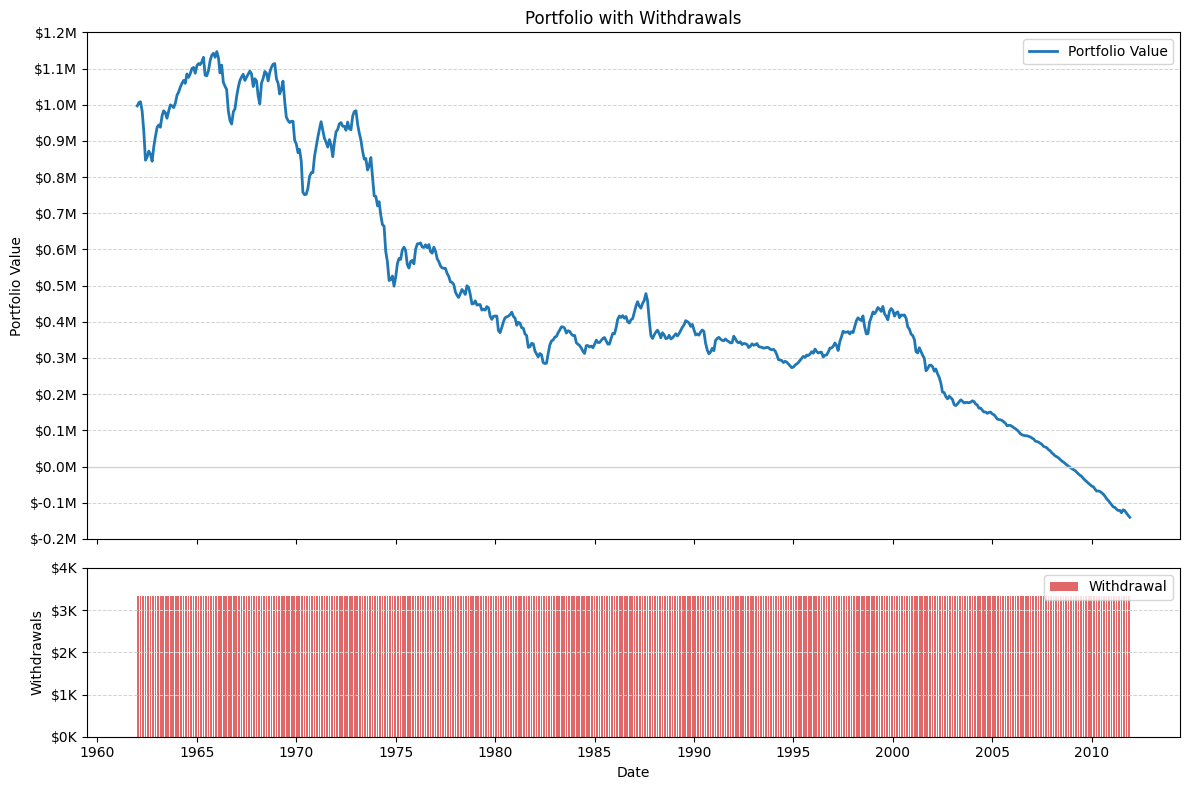

In [19]:
plot_portfolio(four_pct_simulation)

# Dynamic Withdrawals

Now, we want to define a function that will actually adjust the withdrawals at the beginning of each period. The most straightforward way to do this is to look at the portfolio value at the beginning of each month, calculate the withdrawal that yields the desired success rate, and use that new withdrawal for the upcoming period. (Or, alternately, to do that less frequently than every period, e.g. annually.)

First, let's define a function that figures out which withdrawal rate yields the desired portfolio success rate over the period. This function is going to do some heavy lifting: it's a goal-seek operation where we have to pick a starting guess for the withdrawal rate, run all paths with that rate, see how many of them succeed, then adjust and reattempt until we get close enough to the desired value.

In [28]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def get_wr_for_fixed_success_rate(df, desired_success_rate, num_months,
                                   analysis_start_date='1871-01-01',
                                   initial_value=1_000_000, stock_pct=0.75,
                                   tolerance=0.001, max_iterations=50):
    """
    Compute the annual withdrawal rate such that a historical simulation over periods of the desired length
    yields the desired success rate.

    Parameters
    ----------
    df : pd.DataFrame
        The main dataframe with market data
    desired_success_rate : float
        The target chance of underspending (e.g., 0.90 for 90%),
        the percent of simulation paths that should have ending portfolio values > 0.
    num_months : int
        The size of the time window of the historical simulation paths to run
        (corresponds to the remaining time in retirement).
    analysis_start_date : str, optional
        The start date from which we should begin running simulation paths,
        if we do not want to start at the very beginning.
    initial_value : float, optional
        Initial portfolio value (default 1,000,000)
    stock_pct : float, optional
        Percentage of portfolio in stocks (default 0.75)
    tolerance : float, optional
        Tolerance for success rate matching (default 0.001 = 0.1%)
    max_iterations : int, optional
        Maximum iterations for binary search (default 50)

    Returns
    -------
    dict
        Dictionary containing:
        - 'withdrawal_rate': The annual withdrawal rate that achieves the target success rate
        - 'actual_success_rate': The actual success rate achieved
        - 'num_simulations': Number of simulation paths run
        - 'iterations': Number of binary search iterations performed
    """

    # Convert analysis_start_date to datetime
    analysis_start = pd.to_datetime(analysis_start_date)

    # Filter dataframe to only include dates from analysis_start_date onwards
    df_filtered = df[df['Date'] >= analysis_start].copy()

    # Get all possible starting dates for simulation periods
    max_end_idx = len(df_filtered) - num_months
    if max_end_idx <= 0:
        raise ValueError(f"Not enough data for {num_months} month simulations starting from {analysis_start_date}")

    num_paths = max_end_idx + 1

    # Function to calculate success rate for a given withdrawal rate
    def calculate_success_rate(annual_withdrawal_rate):
        # Print start message with timestamp
        start_time = datetime.now()
        print(f"{start_time.strftime('%H:%M:%S')} Starting simulation for WR = {annual_withdrawal_rate:.4f}, "
              f"num_months = {num_months}, num_paths = {num_paths}...")

        successes = 0

        for start_idx in range(num_paths):
            # Define the period for this simulation
            start_date = df_filtered.iloc[start_idx]['Date']
            end_idx = start_idx + num_months - 1
            end_date = df_filtered.iloc[end_idx]['Date']

            # Get withdrawals for this period
            withdrawals = get_constant_withdrawals(
                df_filtered,
                start_date,
                end_date,
                initial_value=initial_value,
                annual_percent_level=annual_withdrawal_rate
            )

            # Run simulation for this period
            simulation_result = run_retirement_simulation(
                df_filtered.iloc[start_idx:end_idx+1],
                withdrawals,
                initial_value=initial_value,
                stock_pct=stock_pct
            )

            # Check if portfolio ever goes to zero or negative
            # A success means ALL values throughout the period are positive
            all_values_positive = (simulation_result['Period End Value'] > 0).all()

            if all_values_positive:
                successes += 1

            # if start_idx > 0 and (start_idx + 1) % 100 == 0:
            #     print(f"Ran {start_idx + 1} paths...")

        # Calculate success rate
        success_rate = successes / num_paths

        # Print completion message with timestamp
        end_time = datetime.now()
        print(f"{end_time.strftime('%H:%M:%S')} ...Done; success rate = {success_rate:.3f}")

        return success_rate

    # Binary search for the withdrawal rate
    low_rate = 0.001  # 0.1% annual withdrawal rate
    high_rate = 0.20   # 20% annual withdrawal rate

    iteration = 0
    best_rate = None
    best_success_rate = None

    print(f"\nSearching for withdrawal rate with {desired_success_rate:.1%} success rate...\n")

    while iteration < max_iterations:
        mid_rate = (low_rate + high_rate) / 2
        current_success_rate = calculate_success_rate(mid_rate)

        # Check if we're within tolerance
        if abs(current_success_rate - desired_success_rate) <= tolerance:
            best_rate = mid_rate
            best_success_rate = current_success_rate
            print(f"\nConverged! Found withdrawal rate within tolerance.\n")
            break

        # Adjust search bounds
        # If success rate is too high, we can withdraw more
        if current_success_rate > desired_success_rate:
            low_rate = mid_rate
            print(f"Success rate too high ({current_success_rate:.3f} > {desired_success_rate:.3f}), "
                  f"increasing withdrawal rate range to [{low_rate:.4f}, {high_rate:.4f}]\n")
        else:
            # If success rate is too low, we need to withdraw less
            high_rate = mid_rate
            print(f"Success rate too low ({current_success_rate:.3f} < {desired_success_rate:.3f}), "
                  f"decreasing withdrawal rate range to [{low_rate:.4f}, {high_rate:.4f}]\n")

        best_rate = mid_rate
        best_success_rate = current_success_rate
        iteration += 1

    if iteration >= max_iterations:
        print(f"\nReached maximum iterations ({max_iterations}). Returning best found rate.\n")

    # Return results
    return {
        'withdrawal_rate': best_rate,
        'actual_success_rate': best_success_rate,
        'num_simulations': num_paths,
        'iterations': iteration + 1
    }

In [29]:

# Example: Find withdrawal rate for 90% success rate over 30-year periods
result = get_wr_for_fixed_success_rate(
    df=df,
    desired_success_rate=0.90,
    num_months=360,  # 30 years
    analysis_start_date='1871-01-01',
    initial_value=1_000_000,
    stock_pct=0.75
)

print(f"Annual withdrawal rate for 90% success rate: {result['withdrawal_rate']:.4f} ({result['withdrawal_rate']*100:.2f}%)")
print(f"Actual success rate achieved: {result['actual_success_rate']:.4f} ({result['actual_success_rate']*100:.2f}%)")
print(f"Number of simulation paths: {result['num_simulations']}")
print(f"Binary search iterations: {result['iterations']}")


Searching for withdrawal rate with 90.0% success rate...

00:54:36 Starting simulation for WR = 0.1005, num_months = 360, num_paths = 1497...
00:55:28 ...Done; success rate = 0.082
Success rate too low (0.082 < 0.900), decreasing withdrawal rate range to [0.0010, 0.1005]

00:55:28 Starting simulation for WR = 0.0508, num_months = 360, num_paths = 1497...
00:56:20 ...Done; success rate = 0.790
Success rate too low (0.790 < 0.900), decreasing withdrawal rate range to [0.0010, 0.0508]

00:56:20 Starting simulation for WR = 0.0259, num_months = 360, num_paths = 1497...
00:57:14 ...Done; success rate = 1.000
Success rate too high (1.000 > 0.900), increasing withdrawal rate range to [0.0259, 0.0508]

00:57:14 Starting simulation for WR = 0.0383, num_months = 360, num_paths = 1497...
00:58:06 ...Done; success rate = 0.994
Success rate too high (0.994 > 0.900), increasing withdrawal rate range to [0.0383, 0.0508]

00:58:06 Starting simulation for WR = 0.0445, num_months = 360, num_paths = 149

That's slow!!!



# WIP - Under Construction

In [ ]:
def get_guardrail_withdrawals(data, start_date, end_date, initial_value=1_000_000, **kwargs):
    """
    Creates a dataframe of withdrawals that follow an adaptive guardrail strategy.
    Description here:  https://youtu.be/-_UtH2WCt2E

    Returns
    -------
    pd.DataFrame
        A dataframe with Date and Withdrawal columns.
    """
    data = data.copy()

    # filter range
    mask = (data["Date"] >= start_date) & (data["Date"] <= end_date)
    subset = data.loc[mask, ["Date"]].reset_index(drop=True)

    previous_spending = 0
    previous_spending_basis_date = '1800-01-01'

    ## Guardrail strategy
    for each date in subset:
        # Calculate the value
        # 1) Recalculate the guardrails based on portfolio value
        # 2) May adjust the spending based on either (a) inflation or (b) spending change IF guardrail is hit

        # TODO rename all variables to match the Main tab of the Everyone Adjusts! spreadsheet

        # To recalculate the guardrails

        # 1. Find the withdrawal rate that results in a 90% success rate from Karsten's sheet - Parameters & Main Results - cell E23 (?).
        #    It has to be done every month because the # in B28 (months remaining) decreases each time. This is the "target" value.

        target_spending = # karsten's calc at 90% WITH CURRENT portfolio value - this will move around

        # 2. Now we have to back out what the portfolio level would be AT this target spending level for the % chance of success to become 100%.
        #    We can either guess and check in Karsten's sheet - or try and replicate what FIRE Calc is doing when we say give me the PF value
        #    we need to make a given spending level a given chance of success.
        #    I am guessing firecalc has a precomputed 3d cube: duration, start date, success %. (And asset allocation but we'll leave that for later)

        upper_guardrail_pf_value = # what firecalc does with the target spending for 100% success rate
        lower_guardrail_pf_value = # what firecalc does with the target spending for 75% success rate

        # 3. Determine if we hit the guardrail. If our current portfolio value is at or above this upper guardrail portfolio value, then we hit it.

        hit_upper_guardrail = portfolio_value > upper_guardrail_pf_value
        hit_lower_guardrail = portfolio_value < lower_guardrail_pf_value

        upper_adjustment_fraction = 1.0
        lower_adjustment_fraction = 0.1

        # 4. If we hit a guardrail, adjust by the configured fraction

        new_proposed_spending = target_spending

        if hit_upper_guardrail:
            new_proposed_spending = target_spending * upper_adjustment_fraction

        if hit_lower_guardrail:
            new_proposed_spending = target_spending * lower_adjustment_fraction

        # 5. We now have to inflation adjust the new proposed spending with a baseline of wherever we last derived it from.
        #    We'll use this to determine if we hit the threshold, but it isn't a meaningful number - it's e.g. a 1960 number adjusted for the period from 1982-1985
        #    (assuming 1982 was the last time we advised the client to adjust their spending). We run the whole simulation in constant dollars, so we don't use this
        #    number for anything else in the math. (We'll *properly* inflation adjust the final spending recommendation before sending it to the client!)

        new_proposed_adj_spending = apply_inflation(new_proposed_spending, previous_spending_basis_date, date)

        # 5. Finally - only adjust spending if this adjusted spending is over configured threshold.
        #    If it is, this means that either guardrail hit and/or

        over_threshold = abs((new_proposed_adj_spending - portfolio_value) / portfolio_value) > 0.05

        if over_threshold:
            new_spending = target_spending * upper_adjustment_fraction
        else:
            new_spending = previous_spending

        subset["Withdrawal"] = withdrawal_value

        # Carry state into the next iteration
        previous_spending = new_spending

    return subset